# CSE 572: Final Project
## Clustering UFC fighters

In [1]:
import re
import pandas as pd
import numpy as np

from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

fight_rounds = pd.read_csv('../Data/fight_rounds.csv')
fights = pd.read_csv('../Data/fights.csv')
fighters = pd.read_csv('../Data/fighters.csv')

Text(0.5, 0.98, 'Distribution Of Fights By Weightclasses')

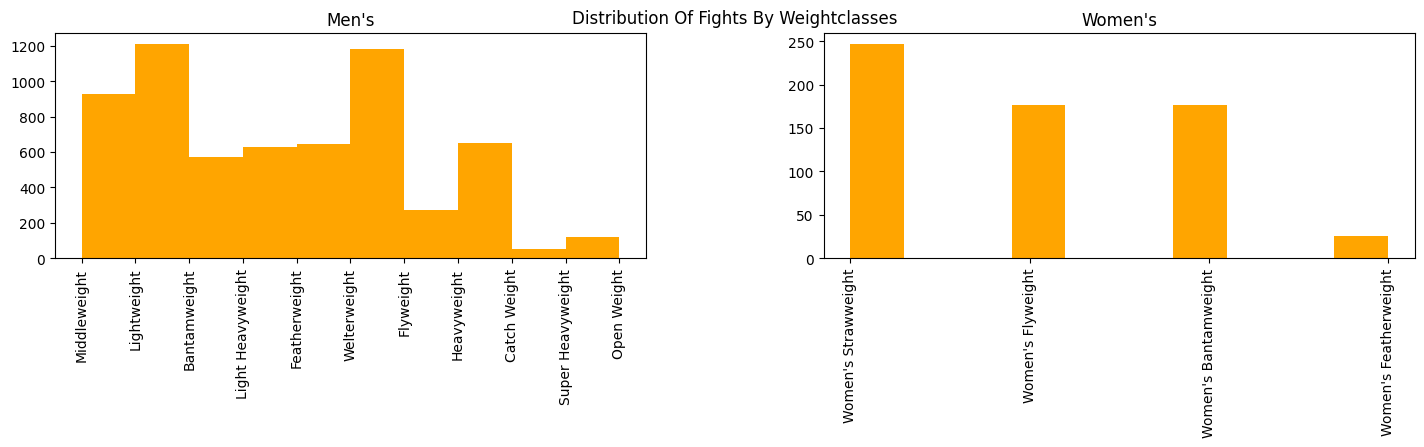

In [2]:
fig, ax = plt.subplots(1,2, figsize=(17,3))
_ = fights['Weight Class'].hist(by=fights['Weight Class'].str.startswith('Women')
  .apply(lambda x: "Women's" if x else "Men's"), ax=ax, color='orange')
fig.suptitle('Distribution of fights by weightclasses'.title())

In [3]:
pivotted = fight_rounds.set_index(['Round', 'Fight Link'], drop=True).unstack('Round')
pivotted.columns = [f"R{col[1]}_{col[0].replace(' ', '_')}" for col in pivotted.columns.values]
pivotted.reset_index(inplace=True)

In [4]:
fights_lite = fights[['Link', 'Fighter1', 'Fighter2', 'Weight Class', 'Finish Type', 'Finish Attack', 'Finish Round', 'F1 Link', 'F2 Link']]
df = fights_lite.merge(pivotted, right_on='Fight Link', left_on='Link').drop(['Link', 'Fight Link'], axis=1)

regex='^\d+ of \d+$'
specimen = df[~df.isna().any(axis=1)].iloc[0]
of_cols = df[specimen.str.contains(regex, na=False).index[specimen.str.contains(regex, na=False)]].columns

pattern = re.compile(r'\d+')
for col in of_cols:
  df[col] = df[col].apply(lambda x: list(map(int, pattern.findall(x))) if isinstance(x, str) else 0)\
  .apply(lambda x: (round(float(x[0]) / float(x[1]), 2) if x[1] else 0) if isinstance(x, list) else 0)

In [5]:
f1_cols = ['Fighter1', 'Weight Class', 'Finish Type', 'Finish Round'] + [col for col in df.columns if 'F1' in col]
f2_cols = ['Fighter2', 'Weight Class', 'Finish Type', 'Finish Round'] + [col for col in df.columns if 'F2' in col]

f1 = df[f1_cols]
f2 = df[f2_cols]

f1.columns = [col\
              .replace('F1', '')\
              .replace('Fighter1', 'Fighter')\
              .replace('__', '_')\
              .strip() for col in f1.columns]
f2.columns = [col\
              .replace('F2', '')\
              .replace('Fighter2', 'Fighter')\
              .replace('__', '_')\
              .strip() for col in f2.columns]

In [6]:
fighter_wise_data = pd.concat([f1, f2]).reset_index(drop=True)
fighter_wise_data = fighters.merge(fighter_wise_data, left_on='Link', right_on='Link')
fighter_wise_data.drop(['Link', 'Fighter', 'Dob', 'Win Loss Record', 'Nick Name'], inplace=True, axis=1)

fighter_wise_data['Takedown Def'] = fighter_wise_data['Takedown Def'].str.replace('%', '').astype('float64')
fighter_wise_data['Takedown Acc'] = fighter_wise_data['Takedown Acc'].str.replace('%', '').astype('float64')
fighter_wise_data['Striking Def'] = fighter_wise_data['Striking Def'].str.replace('%', '').astype('float64')
fighter_wise_data['Striking Acc'] = fighter_wise_data['Striking Acc'].str.replace('%', '').astype('float64')

fighter_wise_data['Reach'] = fighter_wise_data['Reach'].str.replace('"', '', regex=False).replace('--', np.nan).astype('float64')
fighter_wise_data['Weight'] = fighter_wise_data['Weight'].str.replace(' lbs.', '', regex=False).replace('--', np.nan).astype('float64')
fighter_wise_data['R1_Takedown_Perc'] = fighter_wise_data['R1_Takedown_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R2_Takedown_Perc'] = fighter_wise_data['R2_Takedown_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R3_Takedown_Perc'] = fighter_wise_data['R3_Takedown_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R4_Takedown_Perc'] = fighter_wise_data['R4_Takedown_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R5_Takedown_Perc'] = fighter_wise_data['R5_Takedown_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R1_Sig_Strike_Perc'] = fighter_wise_data['R1_Sig_Strike_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R2_Sig_Strike_Perc'] = fighter_wise_data['R2_Sig_Strike_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R3_Sig_Strike_Perc'] = fighter_wise_data['R3_Sig_Strike_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R4_Sig_Strike_Perc'] = fighter_wise_data['R4_Sig_Strike_Perc'].str.replace('%', '').replace('---', 0).astype('float64')
fighter_wise_data['R5_Sig_Strike_Perc'] = fighter_wise_data['R5_Sig_Strike_Perc'].str.replace('%', '').replace('---', 0).astype('float64')

h_regex = r'.*(\d+)\'\s*(\d+).*'
ht_transformer = lambda x: np.nan if x == "--" else float(re.match(h_regex, x).group(1)) + float(re.match(h_regex, x).group(2)) / 12.
fighter_wise_data['Height'] = fighter_wise_data['Height'].apply(ht_transformer).astype('float64')

t_regex = r'^(\d+):(\d+)$'
tm_transformer = lambda x: 0 if str(x) in ["--", "nan"] else int(re.match(t_regex, x).group(1)) + int(re.match(t_regex, x).group(2))
fighter_wise_data['R1_Control_Time'] = fighter_wise_data['R1_Control_Time'].apply(tm_transformer).astype('float64')
fighter_wise_data['R2_Control_Time'] = fighter_wise_data['R2_Control_Time'].apply(tm_transformer).astype('float64')
fighter_wise_data['R3_Control_Time'] = fighter_wise_data['R3_Control_Time'].apply(tm_transformer).astype('float64')
fighter_wise_data['R4_Control_Time'] = fighter_wise_data['R4_Control_Time'].apply(tm_transformer).astype('float64')
fighter_wise_data['R5_Control_Time'] = fighter_wise_data['R5_Control_Time'].apply(tm_transformer).astype('float64')

fighter_wise_data.fillna(fighter_wise_data[['Height', 'Weight', 'Reach']].mean().to_dict(), inplace=True)
fighter_wise_data['Stance'].fillna('Orthodox', inplace=True)
fighter_wise_data.fillna(0, inplace=True)

fighter_names = fighter_wise_data['Name']
fighter_data = fighter_wise_data.drop(['Name'], axis=1)


In [7]:
categorical_cols = ['Stance', 'Weight Class', 'Finish Type']
non_categorical = list(set(fighter_data.columns) - set(categorical_cols))
fighter_data[non_categorical] = MinMaxScaler().fit_transform(fighter_data[non_categorical])

In [8]:
# num_clusters = range(1, 6)
# sse = []

# temp_data = fighter_data.copy()
# for feature in categorical_cols:
#     temp_data[feature] = pd.factorize(temp_data[feature])[0]
# temp_data = temp_data.to_numpy()

# for k in num_clusters:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(temp_data)
#     sse.append(kmeans.inertia_)

# plt.plot(num_clusters, sse)
# plt.xlabel('Number of Clusters')
# plt.ylabel('SSE')

In [9]:
kprototype = KPrototypes(n_clusters = 3, n_jobs=-1)
kprototype.fit_predict(fighter_data.drop(['R1_Leg',
 'R2_Leg',
 'R3_Leg',
 'R4_Leg',
 'R5_Leg',
 'R1_Body',
 'R2_Body',
 'R3_Body',
 'R4_Body',
 'R5_Body',
 'R1_Head',
 'R2_Head',
 'R3_Head',
 'R4_Head',
 'R5_Head',
 'R1_Sig_Strikes',
 'R2_Sig_Strikes',
 'R3_Sig_Strikes',
 'R4_Sig_Strikes',
 'R5_Sig_Strikes',
 'R1_Takedowns',
 'R2_Takedowns',
 'R3_Takedowns',
 'R4_Takedowns',
 'R5_Takedowns'], axis=1), categorical=list(map(fighter_data.columns.get_loc, categorical_cols)))


array([2, 1, 1, ..., 1, 1, 2], dtype=uint16)

In [10]:
orig = fighter_data.copy()
fighter_data['Cluster ID'] = kprototype.labels_
fighter_data['Name'] = fighter_names

pd.set_option('display.max_rows', 1000)
starts = ('khabib', 'yoel', 'daniel corm', 'kamaru', 'israel', 'islam', 'sean o\'m', 'chan sung', 'alexander volkan', 'aljam')

df = fighter_data[fighter_data['Name'].str.lower().str.startswith(starts)][['Name', 'Cluster ID']]
df['cluster_count'] = df.groupby(['Name', 'Cluster ID'])['Name'].transform('count')
df['total_count'] = df.groupby(['Name'])['Name'].transform('count')
df['perc'] = round(df['cluster_count'] * 100 / df['total_count'], 2)

df.drop_duplicates().sort_values('cluster_count', ascending=False).groupby('Name').first().sort_values('Cluster ID')

,Cluster ID,cluster_count,total_count,perc
Name,,,,
Israel Adesanya,0,8,14,57.14
Chan Sung Jung,1,5,11,45.45
Alexander Volkanovski,2,8,12,66.67
Aljamain Sterling,2,12,17,70.59
Daniel Cormier,2,10,15,66.67
Islam Makhachev,2,7,13,53.85
Kamaru Usman,2,7,16,43.75
Khabib Nurmagomedov,2,9,13,69.23
Sean O'Malley,2,5,10,50.00


In [11]:
[col for col in fighter_data.columns]

['Sub Avg',
 'Takedown Def',
 'Takedown Acc',
 'Takedown Avg',
 'Striking Def',
 'Sapm',
 'Striking Acc',
 'Slpm',
 'Stance',
 'Reach',
 'Weight',
 'Height',
 'Weight Class',
 'Finish Type',
 'Finish Round',
 'R1_Ground',
 'R2_Ground',
 'R3_Ground',
 'R4_Ground',
 'R5_Ground',
 'R1_Clinch',
 'R2_Clinch',
 'R3_Clinch',
 'R4_Clinch',
 'R5_Clinch',
 'R1_Distance',
 'R2_Distance',
 'R3_Distance',
 'R4_Distance',
 'R5_Distance',
 'R1_Leg',
 'R2_Leg',
 'R3_Leg',
 'R4_Leg',
 'R5_Leg',
 'R1_Body',
 'R2_Body',
 'R3_Body',
 'R4_Body',
 'R5_Body',
 'R1_Head',
 'R2_Head',
 'R3_Head',
 'R4_Head',
 'R5_Head',
 'R1_Control_Time',
 'R2_Control_Time',
 'R3_Control_Time',
 'R4_Control_Time',
 'R5_Control_Time',
 'R1_Reversals',
 'R2_Reversals',
 'R3_Reversals',
 'R4_Reversals',
 'R5_Reversals',
 'R1_Sub_Attacks',
 'R2_Sub_Attacks',
 'R3_Sub_Attacks',
 'R4_Sub_Attacks',
 'R5_Sub_Attacks',
 'R1_Takedown_Perc',
 'R2_Takedown_Perc',
 'R3_Takedown_Perc',
 'R4_Takedown_Perc',
 'R5_Takedown_Perc',
 'R1_Takedow

In [12]:
kprototype.cost_

671523.6838503917

In [13]:
for feature in categorical_cols:
    orig[feature] = pd.factorize(orig[feature])[0]
    
orig = orig.drop(['R1_Leg',
 'R2_Leg',
 'R3_Leg',
 'R4_Leg',
 'R5_Leg',
 'R1_Body',
 'R2_Body',
 'R3_Body',
 'R4_Body',
 'R5_Body',
 'R1_Head',
 'R2_Head',
 'R3_Head',
 'R4_Head',
 'R5_Head',
 'R1_Sig_Strikes',
 'R2_Sig_Strikes',
 'R3_Sig_Strikes',
 'R4_Sig_Strikes',
 'R5_Sig_Strikes',
 'R1_Takedowns',
 'R2_Takedowns',
 'R3_Takedowns',
 'R4_Takedowns',
 'R5_Takedowns'], axis=1)

kmeans = KMeans(n_clusters=3)
kmeans.fit_predict(orig.to_numpy())

array([0, 0, 0, ..., 2, 0, 0], dtype=int32)

In [14]:
fighter_data['Kmeans ID'] = kmeans.labels_
df1 = fighter_data[fighter_data['Name'].str.lower().str.startswith(starts)][['Name', 'Cluster ID']]
df1['cluster_count'] = df1.groupby(['Name', 'Cluster ID'])['Name'].transform('count')
df1['total_count'] = df1.groupby(['Name'])['Name'].transform('count')
df1['perc1'] = round(df1['cluster_count'] * 100 / df1['total_count'], 2)

df2 = fighter_data[fighter_data['Name'].str.lower().str.startswith(starts)][['Name', 'Kmeans ID']]
df2['cluster_count'] = df2.groupby(['Name', 'Kmeans ID'])['Name'].transform('count')
df2['total_count'] = df2.groupby(['Name'])['Name'].transform('count')
df2['perc2'] = round(df2['cluster_count'] * 100 / df2['total_count'], 2)


df1 = df1.drop_duplicates().sort_values('cluster_count', ascending=False).groupby('Name').first().sort_values('Cluster ID')
df2 = df2.drop_duplicates().sort_values('cluster_count', ascending=False).groupby('Name').first().sort_values('Kmeans ID')
df1.merge(df2, 'inner', left_on='Name', right_on='Name').reset_index()[['Name', 'Cluster ID', 'Kmeans ID', 'perc1', 'perc2']]

,Name,Cluster ID,Kmeans ID,perc1,perc2
0,Israel Adesanya,0,0,57.14,50.00
1,Chan Sung Jung,1,2,45.45,81.82
2,Alexander Volkanovski,2,2,66.67,58.33
3,Aljamain Sterling,2,2,70.59,88.24
4,Daniel Cormier,2,0,66.67,80.00
5,Islam Makhachev,2,0,53.85,84.62
6,Kamaru Usman,2,0,43.75,56.25
7,Khabib Nurmagomedov,2,0,69.23,76.92
8,Sean O'Malley,2,2,50.00,100.00
9,Yoel Romero,2,0,69.23,76.92


In [15]:
from sklearn.metrics import silhouette_score

print(silhouette_score(orig, kprototype.labels_), silhouette_score(orig, kmeans.labels_))

0.09793908800217631 0.1813119277270969


In [16]:
from sklearn.decomposition import PCA
orig_pca = PCA(n_components=2).fit_transform(orig)

k_means_pp_pca = KMeans(n_clusters=3, init='k-means++', n_init=1)
k_means_pp_pca.fit(orig_pca)

KMeans(n_clusters=3, n_init=1)

In [ ]:
# for i in range(1,6): wismer[f'r{i}_head_str_rate'] = data[f'R{i}_Head_Att'] / data[f'R{i}_Total_Strikes_Att']
# for i in range(1,6): wismer[f'r{i}_dist_str_rate'] = data[f'R{i}_Distance_Att'] / data[f'R{i}_Total_Strikes_Att']
# for i in range(1,6): wismer[f'r{i}_sig_str_acc'] = data[f'R{i}_Sig_Strikes_Land'] / data[f'R{i}_Sig_Strikes_Att']
# for i in range(1,6): wismer[f'r{i}_total_str_acc'] = data[f'R{i}_Total_Strikes_Land'] / data[f'R{i}_Total_Strikes_Att']


# if 'fight_count' not in final_cluster_data.columns:
#     fight_count_df = final_cluster_data['name'].value_counts().reset_index()
#     fight_count_df.columns = ['name', 'fight_count']
#     final_cluster_data = final_cluster_data.merge(fight_count_df, left_on='name', right_on='name')

# final_cluster_data['cluster_count'] = final_cluster_data[['name', 'cluster']].groupby(['name', 'cluster'])['name'].transform('count')
# df = final_cluster_data[['name', 'cluster', 'cluster_count']].drop_duplicates().sort_values('cluster_count', ascending=False).groupby('name').first().reset_index()
# df = final_cluster_data.merge(df[['name', 'cluster']], left_on='name', right_on='name')
# final = pd.DataFrame()
# for i in range(3):
#     final[f'Cluster {i}'] = df[df['cluster_y'] == i][['name', 'fight_count']].drop_duplicates().sort_values('fight_count', ascending=False).iloc[:10, 0]
# final